## 1. Loading packages

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import opentnsim.energy

/Users/baart_f/.virtualenvs/opentnsim/lib/python3.9/site-packages/pyproj/__init__.py:91: UserWarning: Valid PROJ data directory not found. Either set the path using the environmental variable PROJ_LIB or with `pyproj.datadir.set_data_dir`.
  warnings.warn(str(err))


## 2. Fixed input values of the model

In [2]:

#input values, ship related (values of M9)

L = 135
B = 11.4
T = 2.75
P_installed = 2200 #kW 

h1 = 10
h2 = 7
h3 = 4
h4 = 3.5

V_0 = np.linspace(0.1, 8, 200)
V_0_km = V_0 * 3.6
#Fixed input values
C_B = 0.85      #block coefficient 
viscosity = 1*10**(-6) #kinematic viscosity
rho = 1000
g = 9.81
x = 2 #number of screws
eta_0 = 0.6     #open water eff
eta_r = 0.98     #relative rotative eff
eta_t = 0.98     #transmission eff
eta_g = 0.96     #gearing eff
c_stern = 0
one_k2 = 2.5 #appendage resistance factor


In [3]:
#Ship related values, calculated from above input values

C_M = 1.006 - 0.0056 * C_B **(-3.56)       #midshipcoefficient
C_wp = (1+2 * C_B)/3                       #waterplane coefficient
C_p = C_B / C_M                            #prismatic coefficient

delta = C_B * L * B * T                    #water displacement

lcb = -13.5 + 19.4 * C_p                   #longitudinal position of the centre of buoyancy as % of L
L_R = L * (1 - C_p + (0.06 * C_p * lcb)/(4 * C_p -1))   #Length of the run

A_T = 0.2 * B * T     #area immersed transom

#Total wet surface area (S_T), wet area of appendages (S_APP) and wet area of flat bottom (S_B)
S_T = L*(2*T + B) * np.sqrt(C_M) * (0.453 + 0.4425 * C_B - 0.2862* C_M - 0.003467 * (B/T) + 0.3696 * C_wp) #+ 2.38 * (A_BT / C_B)
S_APP = 0.05 * S_T
S_B = L * B

#Screw diameter
D_s = 0.7 * T

## 3. Method to calculate different resistance components a ship experiences

Method based on the division of Holtrop & Mennen, with some adjustments made in order to incorporate the shallow water effects

### A) Karpov velocity correction for limited water depths

In [4]:
############ Additional wave making resistance - Karpov #############
R_e = V_0 * L / viscosity

def karpov(h, F_n):
    
    #The Froude number used in the Karpov method is the depth related froude number F_nh
    
    #The different alpha** curves are determined with a sixth power polynomial approximation in Excel
    #A distinction is made between different ranges of Froude numbers, because this resulted in a better approximation of the curve
    
    if F_n <= 0.4:
        
        if 0 <= h/T < 1.75:
            alpha_xx = (-4*10**(-12)) * F_n**3 - 0.2143 * F_n**2 -0.0643 * F_n + 0.9997
        elif 1.75 <= h/T < 2.25:
            alpha_xx = -0.8333 * F_n**3 + 0.25 * F_n**2 - 0.0167 * F_n + 1
        elif 2.25 <= h/T < 2.75:
            alpha_xx = -1.25 * F_n**4 + 0.5833 * F_n**3 - 0.0375 * F_n**2 - 0.0108 * F_n + 1
        elif h/T >= 2.75:
            alpha_xx = 1
    
    elif F_n > 0.4:
        if 0 <= h/T < 1.75:
            alpha_xx = -0.9274 * F_n**6 + 9.5953 * F_n**5 - 37.197 * F_n**4 + 69.666 * F_n**3 - 65.391 * F_n**2 + 28.025 * F_n - 3.4143
        elif 1.75 <= h/T < 2.25:
            alpha_xx = 2.2152 * F_n**6 - 11.852 * F_n**5 + 21.499 * F_n**4 - 12.174 * F_n**3 - 4.7873 * F_n**2 + 5.8662 * F_n - 0.2652
        elif 2.25 <= h/T < 2.75:
            alpha_xx = 1.2205 * F_n**6 - 5.4999 * F_n**5 + 5.7966 * F_n**4 + 6.6491 * F_n**3 - 16.123 * F_n**2 + 9.2016 * F_n - 0.6342
        elif 2.75 <= h/T < 3.25:
            alpha_xx = -0.4085 * F_n**6 + 4.534 * F_n**5 - 18.443 * F_n**4 + 35.744 * F_n**3 - 34.381 * F_n**2 + 15.042 * F_n - 1.3807
        elif 3.25 <= h/T < 3.75:
            alpha_xx = 0.4078 * F_n **6 - 0.919 * F_n**5 - 3.8292 * F_n**4 + 15.738 * F_n**3 - 19.766 * F_n**2 + 9.7466 * F_n - 0.6409
        elif 3.75 <= h/T < 4.5:
            alpha_xx = 0.3067 * F_n**6 - 0.3404 * F_n**5 - 5.0511 * F_n**4 + 16.892 * F_n**3 - 20.265 * F_n**2 + 9.9002 * F_n - 0.6712
        elif 4.5 <= h/T < 5.5:
            alpha_xx = 0.3212 * F_n**6 - 0.3559 * F_n**5 - 5.1056 * F_n**4 + 16.926 * F_n**3 - 20.253 * F_n**2 + 10.013 * F_n - 0.7196
        elif 5.5 <= h/T < 6.5:
            alpha_xx = 0.9252 * F_n**6 - 4.2574 * F_n**5 + 5.0363 * F_n **4 + 3.3282 * F_n**3 - 10.367 * F_n**2 + 6.3993 * F_n - 0.2074
        elif 6.5 <= h/T < 7.5:
            alpha_xx = 0.8442 * F_n**6 - 4.0261 * F_n**5 + 5.313 * F_n **4 + 1.6442 * F_n**3 - 8.1848 * F_n**2 + 5.3209 * F_n - 0.0267
        elif 7.5 <= h/T < 8.5:
            alpha_xx = 0.1211 * F_n**6 + 0.628 * F_n**5 - 6.5106 * F_n**4 + 16.7 * F_n**3 - 18.267 * F_n**2 + 8.7077 * F_n - 0.4745
        
                
        elif 8.5 <= h/T < 9.5:
            if F_n < 0.6:
                alpha_xx = 1
            elif F_n >= 0.6:
                alpha_xx = -6.4069 * F_n**6 + 47.308 * F_n**5 - 141.93 * F_n**4 + 220.23 * F_n**3 - 185.05 * F_n**2 + 79.25 * F_n - 12.484
        elif h/T >= 9.5: 
            if F_n < 0.6:
                alpha_xx = 1
            elif F_n >= 0.6:
                alpha_xx = -6.0727 * F_n**6 + 44.97 * F_n**5 - 135.21 * F_n**4 + 210.13 * F_n**3 - 176.72 * F_n**2 + 75.728 * F_n - 11.893
    
    return alpha_xx


In [5]:
h1 = 10
h2 = 7
h3 = 4
h4 = 3.5
h5 = 3

F_nh1 = V_0 / np.sqrt(g * h1)
F_nh2 = V_0 / np.sqrt(g * h2)
F_nh3 = V_0 / np.sqrt(g * h3)
F_nh4 = V_0 / np.sqrt(g * h4)
F_nh5 = V_0 / np.sqrt(g * h4)

#The corrected velocity V2 (Karpov) is going to be applied in all resistance components of the Holtrop and Mennen method
#Except for frictional resistance

V2_1 = np.zeros(len(F_nh1))
V2_2 = np.zeros(len(F_nh1))
V2_3 = np.zeros(len(F_nh1))
V2_4 = np.zeros(len(F_nh1))
V2_5 = np.zeros(len(F_nh1))

for i in range(len(F_nh1)):
    V2_1[i] = V_0[i] / karpov(h1, F_nh1.item(i))
    V2_2[i] = V_0[i] / karpov(h2, F_nh2.item(i))
    V2_3[i] = V_0[i] / karpov(h3, F_nh3.item(i))
    V2_4[i] = V_0[i] / karpov(h4, F_nh4.item(i))
    V2_5[i] = V_0[i] / karpov(h5, F_nh5.item(i))

### B) Frictional resistance and appendage resistance (dependend on V0 and h) 

In [6]:
#Section 2.2 Resistance

#Section 2.2.1 Frictional resistance
#Section 2.2.3 Appendage resistance

#### Method of Zeng(2019) incorporating the shallow water effect in the frictional resistance term #######

def frictional_resistance(h):
    R_e = V_0 * L / viscosity
    D = h - T #distance from bottom ship to the bottom of the fairway

    Cf_0 = 0.075 / ((np.log10(R_e)-2)**2)
    
    Cf_proposed = (0.08169/((np.log10(R_e) - 1.717)**2)) * (1 + (0.003998/(np.log10(R_e) - 4.393)) * (D/L)**(-1.083))

    a = 0.042612 * np.log10(R_e) + 0.56725
    
    Cf_katsui = 0.0066577 / ((np.log10(R_e) - 4.3762)**a)

    if h/T <= 4:
        V_B = 0.4277 * V_0 * np.exp((h / T)**(-0.07625))
    else:
        V_B = V_0

    C_f = Cf_0 + (Cf_proposed - Cf_katsui) * (S_B / S_T) * (V_B / V_0)**2

    R_f = (C_f * 0.5 * rho * (V_0**2) * S_T) / 1000 #kN
    
    R_APP = (0.5 * rho * (V_0**2) * S_APP * one_k2 * C_f) / 1000 #kN
    
    return R_f, R_APP, V_B, C_f, Cf_0

### C) Viscous resistance 

In [7]:
#Section 2.2.2 Viscous resistance

c_14 = 1 + 0.0011 * c_stern
one_k1 = 0.93+0.487 * c_14 * ((B/L)**1.068) * ((T/L)**0.461) * ((L/L_R)**0.122) * (((L**3)/delta)**0.365) * ((1 - C_p)**(-0.604))

### D) Wave resistance  (dependend on V2)

In [8]:
# #This is Holtrop & Mennen's Rw
def wave_resistance(V_2):
    F_nL = V_2 / np.sqrt(g*L) #Froude number

#parameter c_7 is determined by the B/L ratio
    if B/L < 0.11:
        c_7 = 0.229577 * (B/L)**0.33333
    elif B/L > 0.25:
        c_7 = 0.5 - 0.0625 * (L/B)
    else: 
        c_7 = B/L

#parameter c_16 depends on C_p
    if C_p < 0.8:
        c_16 = 8.07981 * C_p - 13.8673 * (C_p**2) + 6.984388 * (C_p**3)
    else:
        c_16 = 1.73014 - 0.7067 * C_p

#parameter c_15 depoends on the ratio L^3 / delta
    if (L**3) / delta < 512:
        c_15 = -1.69385
    elif (L**3) / delta > 1727:
        c_15 = 0
    else:
        c_15 = -1.69385 + (L / (delta**(1/3)) - 8) / 2.36
#half angle of entrance in degrees
    i_E = 1 + 89 * np.exp(-((L/B)**0.80856) * ((1 - C_wp)**0.30484) * ((1 - C_p - 0.0225 * lcb)**0.6367) * ((L_R / B)**0.34574) * ((100 * delta / (L**3))**0.16302))

    c_1 = 2223105 * (c_7**3.78613) * ((T/B)**1.07961) * (90 - i_E)**(-1.37165) 
    c_2 = 1 #accounts for the effect of the bulbous bow, which is not present at inland ships
    c_5 = 1 - (0.8 * A_T) / (B * T * C_M) #influence of the transom stern on the wave resistance
    if L/B < 12:
         lmbda = 1.446 * C_p - 0.03 * (L/B)
    else: 
         lmbda = 1.446 * C_p - 0.36

    m_1 = 0.0140407 * (L / T) - 1.75254 * ((delta)**(1/3) / L) - 4.79323 * (B / L) - c_16  
    m_2=c_15 * (C_p**2) *np.exp((-0.1)* (F_nL**(-2))) 
    R_W = c_1 * c_2 * c_5 * delta * rho * g * np.exp(m_1 * (F_nL**(-0.9)) + m_2 * np.cos(lmbda * (F_nL**(-2))))/1000 

    return R_W


In [9]:
# #Section 2.2.4 Wave resistance



# def wave_resistance(V_2):

# #This method is based on literature of Sarris (Naval Ship Propulsion and Electric Power Systems Selection for
# #Optimal Fuel Consumption) (2003) applying Holtrop and Mennen (pag 26)

#     F_n = V_2 / np.sqrt(g*L) #Froude number


#     #parameter c_7 is determined by the B/L ratio
#     if B/L < 0.11:
#         c_7 = 0.229577 * (B/L)**0.33333
#     elif B/L > 0.25:
#         c_7 = 0.5 - 0.0625 * (L/B)
#     else: 
#         c_7 = B/L

#     #half angle of entrance in degrees
#     i_E = 1 + 89 * np.exp(-((L/B)**0.80856) * ((1 - C_wp)**0.30484) * ((1 - C_p - 0.0225 * lcb)**0.6367) * ((L_R / B)**0.34574) * ((100 * delta / (L**3))**0.16302))

#     c_1 = 2223105 * (c_7**3.78613) * ((T/B)**1.07961) * (90 - i_E)**(-1.37165) 
#     c_2 = 1 #accounts for the effect of the bulbous bow, which is not present at inland ships
#     c_5 = 1 - (0.8 * A_T) / (B * T * C_M) #influence of the transom stern on the wave resistance

#     #parameter c_15 depoends on the ratio L^3 / delta
#     if (L**3) / delta < 512:
#         c_15 = -1.69385
#     elif (L**3) / delta > 1727:
#         c_15 = 0
#     else:
#         c_15 = -1.69385 + (L / (delta**(1/3)) - 8) / 2.36

#     #parameter c_16 depends on C_p
#     if C_p < 0.8:
#         c_16 = 8.07981 * C_p - 13.8673 * (C_p**2) + 6.984388 * (C_p**3)
#     else:
#         c_16 = 1.73014 - 0.7067 * C_p

#     m_1 = 0.0140407 * (L / T) - 1.75254 * ((delta)**(1/3) / L) - 4.79323 * (B / L) - c_16

#     m_4 = 0.4 * c_15 * np.exp(-0.034 * (F_n**(-3.29)))    

#     if L/B < 12:
#         lmbda = 1.446 * C_p - 0.03 * (L/B)
#     else: 
#         lmbda = 1.446 * C_p - 0.36

#     #parameters needed for RW_2
#     c_17 = 6919.3 * (C_M**(-1.3346)) * ((delta/ (L**3))**2.00977) * ((L/B - 2)**1.40692)
#     m_3 = -7.2035 * ((B / L)**0.326869) * ((T/B)**0.605375)


#     ######### When Fn < 0.4
#     RW_1 = c_1 * c_2 * c_5 * delta * rho * g * np.exp(m_1 * (F_n**(-0.9)) + m_4 * np.cos(lmbda * (F_n**(-2)))) 

#     ######## When Fn > 0.5
#     RW_2 = c_17 * c_2 * c_5 * delta * rho * g * np.exp(m_3 * (F_n**(-0.9)) + m_4 * np.cos(lmbda * (F_n**(-2))))
    
#     if F_n < 0.4:
#         R_W = RW_1 / 1000 #kN
#     elif F_n > 0.55:
#         R_W = RW_2 / 1000 #kN
#     else:
#         R_W = (RW_1 + ((10 * F_n - 4) * (RW_2 - RW_1)) / 1.5) / 1000 #kN
        
#     return R_W

In [10]:
R_W_1 = np.zeros(len(V_0))
R_W_2 = np.zeros(len(V_0))
R_W_3 = np.zeros(len(V_0))
R_W_4 = np.zeros(len(V_0))
R_W_5 = np.zeros(len(V_0))

for i in range(len(V_0)):
    R_W_1[i] = wave_resistance(V2_1.item(i))
    R_W_2[i] = wave_resistance(V2_2.item(i))
    R_W_3[i] = wave_resistance(V2_3.item(i))
    R_W_4[i] = wave_resistance(V2_4.item(i))
    R_W_5[i] = wave_resistance(V2_5.item(i))

### E) Residual resistance terms 

In [11]:
#Section 2.2.5 Residual resistance terms


#Resistance due to immersed transom
def resistance_transom(V_2):
    F_nt = V_2 / np.sqrt(2 * g * A_T / (B + B * C_wp))

    c_6 = 0.2 * (1 - 0.2 * F_nt)

    R_TR = (0.5 * rho * (V_2**2) * A_T * c_6) / 1000 #kN
    
    return R_TR

#Model-ship correlation resistance
def resistance_model_correlation(V_2):
    if T / L < 0.04:
        c_4 = T / L
    else:
        c_4 = 0.04
    c_2 = 1
    
    C_A = 0.006 * (L + 100)**(-0.16) - 0.00205 + 0.003 * np.sqrt(L / 7.5) * (C_B**4) * c_2 * (0.04 - c_4)

    #C_A = (1.8 + 260/L) * 0.0001 #Holtrop 1977

    ####### Holtrop and Mennen in the document of Sarris, 2003 #######
    R_A = (0.5 * rho * (V_2**2) * S_T * C_A) / 1000 #kW
    
    return R_A

In [12]:
R_TR_1 = np.zeros(len(V_0))
R_TR_2 = np.zeros(len(V_0))
R_TR_3 = np.zeros(len(V_0))
R_TR_4 = np.zeros(len(V_0))
R_TR_5 = np.zeros(len(V_0))

for i in range(len(V_0)):
    R_TR_1[i] = resistance_transom(V2_1.item(i))
    R_TR_2[i] = resistance_transom(V2_2.item(i))
    R_TR_3[i] = resistance_transom(V2_3.item(i))
    R_TR_4[i] = resistance_transom(V2_4.item(i))
    R_TR_5[i] = resistance_transom(V2_5.item(i))

In [13]:
R_A_1 = np.zeros(len(V_0))
R_A_2 = np.zeros(len(V_0))
R_A_3 = np.zeros(len(V_0))
R_A_4 = np.zeros(len(V_0))
R_A_5 = np.zeros(len(V_0))

for i in range(len(V_0)):
    R_A_1[i] = resistance_model_correlation(V2_1.item(i))
    R_A_2[i] = resistance_model_correlation(V2_2.item(i))
    R_A_3[i] = resistance_model_correlation(V2_3.item(i))
    R_A_4[i] = resistance_model_correlation(V2_4.item(i))
    R_A_5[i] = resistance_model_correlation(V2_5.item(i))

## 4. Total resistance of a single ship, for different water depth, as a function of V0

In [14]:
#Section 2.2 Resistance

#Total resistance

#R_tot = R_f * one_k1 + R_APP + R_W + R_TR + R_A

#For water depth h1 = 10 m
R_tot1 = frictional_resistance(h1)[0] * one_k1 + frictional_resistance(h1)[1] + R_W_1 + R_TR_1 + R_A_1

#For water depth h2 = 7 m
R_tot2 = frictional_resistance(h2)[0] * one_k1 + frictional_resistance(h2)[1] + R_W_2 + R_TR_2 + R_A_2

#For water depth h3 = 4 m 
R_tot3 = frictional_resistance(h3)[0] * one_k1 + frictional_resistance(h3)[1] + R_W_3 + R_TR_3 + R_A_3

#For water depth h4 = 3.5 m
R_tot4 = frictional_resistance(h4)[0] * one_k1 + frictional_resistance(h4)[1] + R_W_4 + R_TR_4 + R_A_4

#For water depth h5 = 3 m 
R_tot5 = frictional_resistance(h5)[0] * one_k1 + frictional_resistance(h5)[1] + R_W_5 + R_TR_5 + R_A_5

### Resistance plot

#### Plotting the total resistance as a function of V0, for different water depths

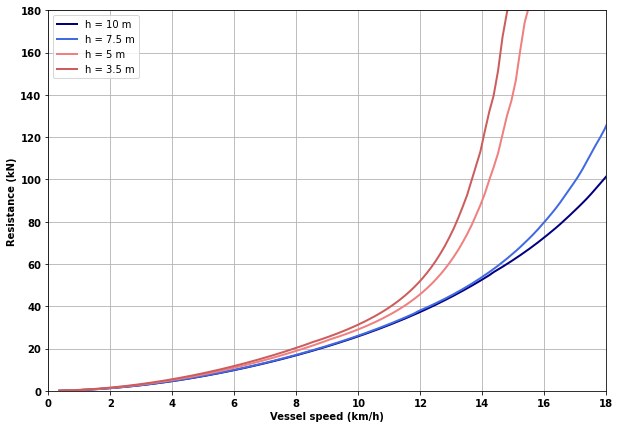

In [15]:

plt.figure(figsize = (10,7))
plt.plot(V_0_km, R_tot1, 'navy',linewidth = 2.0)
plt.plot(V_0_km, R_tot2, 'royalblue',linewidth = 2.0)
plt.plot(V_0_km, R_tot3, 'lightcoral',linewidth = 2.0)
plt.plot(V_0_km, R_tot4, 'indianred',linewidth = 2.0)
#plt.plot(V_0_km, R_tot5, 'firebrick',linewidth = 2.0)
plt.grid()
plt.xlim(0, 18)
plt.ylim(0,180)
plt.legend(['h = 10 m', 'h = 7.5 m', 'h = 5 m', 'h = 3.5 m'])
plt.xlabel('Vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('Resistance (kN)',fontsize=10,weight='bold',labelpad=3)
#plt.title('Vessel speed versus resistance (type = M9, L = 135 m, B = 11.45 m, T = 2.75 m)')
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold')
plt.savefig('resistance versus speed with diff water depths.pdf', dpi=600, format='pdf') 

## 5. Power a ship requires

In [16]:
#Section 2.1 Total required power

#2.1.1 Required power for systems on board
P_hotel = 0.05 * P_installed #5% just an assumption for now

#2.1.2 Required power for propulsion



#Calculation hull efficiency

#Based on Van Terwisga (1989)
dw = 0 
    
w = 0.11 * (0.16 / x) * C_B * np.sqrt((delta**(1/3)) / D_s) - dw

if x == 1:
    t = 0.6 * w * (1 + 0.67 * w)
else:
    t = 0.8 * w * (1 + 0.25 * w)
    
eta_h = (1 - t) / (1 - w)


#Effective Horse Power (EHP)

#P_EHP = V_B * R_tot
#V_B is defined in the frictional resistance function


#P_tot1 = P_hotel + (frictional_resistance(h1)[2] * R_tot1) / (eta_0 * eta_r * eta_h * eta_t * eta_g)

P_tot1 = P_hotel + (V_0 * R_tot1) / (eta_0 * eta_r * eta_h * eta_t * eta_g)

P_tot2 = P_hotel + (V_0 * R_tot2) / (eta_0 * eta_r * eta_h * eta_t * eta_g)

P_tot3 = P_hotel + (V_0 * R_tot3) / (eta_0 * eta_r * eta_h * eta_t * eta_g)

P_tot4 = P_hotel + (V_0 * R_tot4) / (eta_0 * eta_r * eta_h * eta_t * eta_g)

P_tot5 = P_hotel + (V_0 * R_tot5) / (eta_0 * eta_r * eta_h * eta_t * eta_g)

### Power plots

(array([   0.,  250.,  500.,  750., 1000., 1250., 1500., 1750., 2000.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

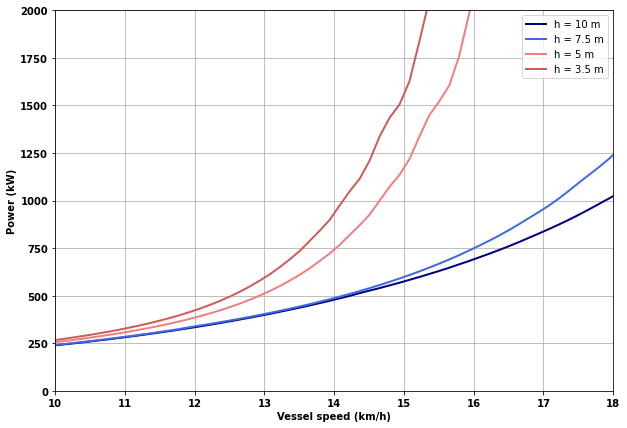

In [17]:
plt.figure(figsize = (10,7))
plt.plot(V_0_km, P_tot1, 'navy',linewidth = 2.0)
plt.plot(V_0_km, P_tot2, 'royalblue',linewidth = 2.0)
plt.plot(V_0_km, P_tot3, 'lightcoral',linewidth = 2.0)
plt.plot(V_0_km, P_tot4, 'indianred',linewidth = 2.0)
#plt.plot(V_0_km, P_tot5, 'firebrick')
plt.grid()
plt.xlim(10, 18)
plt.ylim(0, 2000)
plt.legend(['h = 10 m', 'h = 7.5 m', 'h = 5 m', 'h = 3.5 m'])

plt.xlabel('Vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('Power (kW)',fontsize=10,weight='bold',labelpad=3)
#plt.title('Vessel speed versus resistance (type = M9, L = 135 m, B = 11.45 m, T = 2.75 m)')
plt.xticks( weight = 'bold')
plt.yticks( weight = 'bold')
#plt.savefig('total power required versus speed with diff water depths.pdf', dpi=600, format='pdf') 


## 6. Emissions

### Emission factors general

In [18]:
P_partial1 = P_tot1 / P_installed

P_partial2 = P_tot2 / P_installed

P_partial3 = P_tot3 / P_installed

P_partial4 = P_tot4 / P_installed

P_partial5 = P_tot5 / P_installed

for i in range (len(P_partial1)):
    if P_partial1[i] > 1:
        P_partial1[i] = 1

    elif P_partial2[i] > 1:
        P_partial2[i] = 1

    elif P_partial3[i] > 1:
        P_partial3[i] = 1

    elif P_partial4[i] > 1:
        P_partial4[i] = 1

    elif P_partial5[i] > 1:
        P_partial5[i] = 1
    
c_year = 1970 #hardcoded, is in the model depended on weibull function
c_year1 = 1980
c_year2 = 1990
c_year3 = 2000
c_year4 = 2010
c_year5 = 2020


In [19]:
def general_emissionfactor(c_year, L_w):
    if c_year < 1974:
        EM_CO2 = 756
        EM_PM10 = 0.6
        EM_NOX = 10.8
    elif 1975 <= c_year <= 1979:
        EM_CO2 = 730
        EM_PM10 = 0.6
        EM_NOX = 10.6
    elif 1980 <= c_year <= 1984:
        EM_CO2 = 714
        EM_PM10 = 0.6
        EM_NOX = 10.4
    elif 1985 <= c_year <= 1989:
        EM_CO2 = 698
        EM_PM10 = 0.5
        EM_NOX = 10.1
    elif 1990 <= c_year <= 1994:
        EM_CO2 = 698
        EM_PM10 = 0.4
        EM_NOX = 10.1
    elif 1995 <= c_year <= 2002:
        EM_CO2 = 650
        EM_PM10 = 0.3
        EM_NOX = 9.4
    elif 2003 <= c_year <= 2007:
        EM_CO2 = 635
        EM_PM10 = 0.3
        EM_NOX = 9.2
    elif 2008 <= c_year <= 2019:
        EM_CO2 = 635
        EM_PM10 = 0.2
        EM_NOX = 7
    elif c_year > 2019:
        if L == 1:
            EM_CO2 = 650
            EM_PM10 = 0.1
            EM_NOX = 2.9
        else:
            EM_CO2 = 603
            EM_PM10 = 0.015
            EM_NOX = 2.4
    return EM_CO2, EM_PM10, EM_NOX

general_emf = general_emissionfactor(c_year, 3)
general_emf1 = general_emissionfactor(c_year1, 3)
general_emf2 = general_emissionfactor(c_year2, 3)
general_emf3 = general_emissionfactor(c_year3, 3)
general_emf4 = general_emissionfactor(c_year4, 3)
general_emf5= general_emissionfactor(c_year5, 3)

### Correction factors

In [2]:
corf_CO2 = np.zeros(len(V_0))
corf_PM10 = np.zeros(len(V_0))
corf_NOX = np.zeros(len(V_0))

def correctionfactor(c_year, P_partial, L_w=3):
    corf = opentnsim.energy.correction_factors()
    
    corf_CO2 = 0
    corf_PM10 = 0
    corf_NOX = 0
    
    #If P_partial is <= 5%
    
    if P_partial <= 0.05:
        corf_CO2 = corf.iloc[0, 5]
        corf_PM10 = corf.iloc[0, 6]
            
        if c_year < 2008:
            corf_NOX = corf.iloc[0, 1] #<= CCR-1 class
        elif 2008 <= c_year <= 2019:
            corf_NOX = corf.iloc[0, 2] #CCR-2 / Stage IIIa
        elif c_year > 2019:
                if L_w == 1:
                    corf_NOX = corf.iloc[0, 3] #Stage V: IWP/IWA-v/c-3 class (vessels with P <300 kW: assumed to be weight class L1)
                else:
                    corf_NOX = corf.iloc[0, 4]  #Stage V:IWP/IWA-v/c-4 class (vessels with P >300 kw: assumed to be weight class L2-L3)
    
    #If P_parital = 100% 
    
    elif P_partial == 1:
        corf_CO2 = corf.iloc[19, 5]
        corf_PM10 = corf.iloc[19, 6]
            
        if c_year < 2008:
            corf_NOX = corf.iloc[19, 1] #<= CCR-1 class
        elif 2008 <= c_year <= 2019:
            corf_NOX = corf.iloc[19, 2] #CCR-2 / Stage IIIa
        elif c_year > 2019:
            if L_w == 1:
                corf_NOX = corf.iloc[19, 3] #Stage V: IWP/IWA-v/c-3 class (vessels with P <300 kW: assumed to be weight class L1)
            else:
                corf_NOX = corf.iloc[19, 4]  #Stage V:IWP/IWA-v/c-4 class (vessels with P >300 kw: assumed to be weight class L2-L3) 
                
    #If P_partial is inbetween 5% and 100%. 
            
    elif 0.05 < P_partial < 1:
    
        #It is determined inbetween which two percentages in the table the partial engine load lies
        #The correction factor is determined by means of linear interpolation  
            
        for i in range(len(corf)):
            if corf.iloc[i, 0] < P_partial <= corf.iloc[i + 1, 0]: 
                
                corf_CO2 = ((P_partial - corf.iloc[i, 0]) * (corf.iloc[i+1, 5] - corf.iloc[i, 5])) / (corf.iloc[i+1, 0] - corf.iloc[i, 0]) + corf.iloc[i, 5]
                corf_PM10 = ((P_partial - corf.iloc[i, 0]) * (corf.iloc[i+1, 6] - corf.iloc[i, 6])) / (corf.iloc[i+1, 0] - corf.iloc[i, 0]) + corf.iloc[i, 6]

                if c_year < 2008:
                    corf_NOX = ((P_partial - corf.iloc[i, 0]) * (corf.iloc[i+1, 1] - corf.iloc[i, 1])) / (corf.iloc[i+1, 0] - corf.iloc[i, 0]) + corf.iloc[i, 1]
                elif 2008 <= c_year <= 2019:
                    corf_NOX = ((P_partial - corf.iloc[i, 0]) * (corf.iloc[i+1, 2] - corf.iloc[i, 2])) / (corf.iloc[i+1, 0] - corf.iloc[i, 0]) + corf.iloc[i, 2]
                elif c_year > 2019:
                    if L_w == 1:
                        corf_NOX = ((P_partial - corf.iloc[i, 0]) * (corf.iloc[i+1, 3] - corf.iloc[i, 3])) / (corf.iloc[i+1, 0] - corf.iloc[i, 0]) + corf.iloc[i, 3]
                    else:
                        corf_NOX = ((P_partial - corf.iloc[i, 0]) * (corf.iloc[i+1, 4] - corf.iloc[i, 4])) / (corf.iloc[i+1, 0] - corf.iloc[i, 0]) + corf.iloc[i, 4] 
    return corf_CO2, corf_PM10, corf_NOX

NameError: name 'V_0' is not defined

### Emission rates plots

In [21]:
#Emission rates for different water depths in g/h

emission_rate_CO2_1 = np.zeros(len(V_0))
emission_rate_CO2_2 = np.zeros(len(V_0))
emission_rate_CO2_3 = np.zeros(len(V_0))
emission_rate_CO2_4 = np.zeros(len(V_0))
emission_rate_CO2_5 = np.zeros(len(V_0))

emission_rate_PM10_1= np.zeros(len(V_0))
emission_rate_PM10_2= np.zeros(len(V_0))
emission_rate_PM10_3= np.zeros(len(V_0))
emission_rate_PM10_4= np.zeros(len(V_0))
emission_rate_PM10_5= np.zeros(len(V_0))

emission_rate_NOX_1 = np.zeros(len(V_0))
emission_rate_NOX_2 = np.zeros(len(V_0))
emission_rate_NOX_3 = np.zeros(len(V_0))
emission_rate_NOX_4 = np.zeros(len(V_0))
emission_rate_NOX_5 = np.zeros(len(V_0))

for i in range(len(V_0)):
    emission_rate_CO2_1[i] = P_tot1.item(i) * general_emf[0] * correctionfactor(c_year, P_partial1.item(i), 3)[0]
    emission_rate_CO2_2[i] = P_tot2.item(i) * general_emf[0] * correctionfactor(c_year, P_partial2.item(i), 3)[0]
    emission_rate_CO2_3[i] = P_tot3.item(i) * general_emf[0] * correctionfactor(c_year, P_partial3.item(i), 3)[0]
    emission_rate_CO2_4[i] = P_tot4.item(i) * general_emf[0] * correctionfactor(c_year, P_partial4.item(i), 3)[0]
    emission_rate_CO2_5[i] = P_tot5.item(i) * general_emf[0] * correctionfactor(c_year, P_partial5.item(i), 3)[0]
    
for i in range(len(V_0)):
    emission_rate_PM10_1[i] = P_tot1.item(i) * general_emf[1] * correctionfactor(c_year, P_partial1.item(i), 3)[1]
    emission_rate_PM10_2[i] = P_tot2.item(i) * general_emf[1] * correctionfactor(c_year, P_partial2.item(i), 3)[1]
    emission_rate_PM10_3[i] = P_tot3.item(i) * general_emf[1] * correctionfactor(c_year, P_partial3.item(i), 3)[1]
    emission_rate_PM10_4[i] = P_tot4.item(i) * general_emf[1] * correctionfactor(c_year, P_partial4.item(i), 3)[1]
    emission_rate_PM10_5[i] = P_tot5.item(i) * general_emf[1] * correctionfactor(c_year, P_partial5.item(i), 3)[1]

for i in range(len(V_0)):
    emission_rate_NOX_1[i] = P_tot1.item(i) * general_emf[2] * correctionfactor(c_year, P_partial1.item(i), 3)[2]
    emission_rate_NOX_2[i] = P_tot2.item(i) * general_emf[2] * correctionfactor(c_year, P_partial2.item(i), 3)[2]
    emission_rate_NOX_3[i] = P_tot3.item(i) * general_emf[2] * correctionfactor(c_year, P_partial3.item(i), 3)[2]
    emission_rate_NOX_4[i] = P_tot4.item(i) * general_emf[2] * correctionfactor(c_year, P_partial4.item(i), 3)[2]
    emission_rate_NOX_5[i] = P_tot5.item(i) * general_emf[2] * correctionfactor(c_year, P_partial5.item(i), 3)[2]



#print(emission_rate_PM10_1)

#emission_rate_CO2 = P_tot1 * general_emf[0] * correctionfactor(c_year, P_partial1, 3)

In [22]:
#Emission rates in g/km for different water depths

emission_g_m_CO2_1 = np.zeros(len(V_0))
emission_g_m_CO2_2 = np.zeros(len(V_0))
emission_g_m_CO2_3 = np.zeros(len(V_0))
emission_g_m_CO2_4 = np.zeros(len(V_0))
emission_g_m_CO2_5 = np.zeros(len(V_0))

emission_g_m_PM10_1= np.zeros(len(V_0))
emission_g_m_PM10_2= np.zeros(len(V_0))
emission_g_m_PM10_3= np.zeros(len(V_0))
emission_g_m_PM10_4= np.zeros(len(V_0))
emission_g_m_PM10_5= np.zeros(len(V_0))

emission_g_m_NOX_1 = np.zeros(len(V_0))
emission_g_m_NOX_2 = np.zeros(len(V_0))
emission_g_m_NOX_3 = np.zeros(len(V_0))
emission_g_m_NOX_4 = np.zeros(len(V_0))
emission_g_m_NOX_5 = np.zeros(len(V_0))

for i in range(len(V_0)):
    emission_g_m_CO2_1[i] = P_tot1.item(i) * general_emf[0] * correctionfactor(c_year, P_partial1.item(i), 3)[0] /  V_0_km[i]
    emission_g_m_CO2_2[i] = P_tot2.item(i) * general_emf[0] * correctionfactor(c_year, P_partial2.item(i), 3)[0] /  V_0_km[i]
    emission_g_m_CO2_3[i] = P_tot3.item(i) * general_emf[0] * correctionfactor(c_year, P_partial3.item(i), 3)[0] /  V_0_km[i]
    emission_g_m_CO2_4[i] = P_tot4.item(i) * general_emf[0] * correctionfactor(c_year, P_partial4.item(i), 3)[0] /  V_0_km[i]
    emission_g_m_CO2_5[i] = P_tot5.item(i) * general_emf[0] * correctionfactor(c_year, P_partial5.item(i), 3)[0] /  V_0_km[i]
    
for i in range(len(V_0)):
    emission_g_m_PM10_1[i] = P_tot1.item(i) * general_emf[1] * correctionfactor(c_year, P_partial1.item(i), 3)[1] /  V_0_km[i]
    emission_g_m_PM10_2[i] = P_tot2.item(i) * general_emf[1] * correctionfactor(c_year, P_partial2.item(i), 3)[1] /  V_0_km[i]
    emission_g_m_PM10_3[i] = P_tot3.item(i) * general_emf[1] * correctionfactor(c_year, P_partial3.item(i), 3)[1] /  V_0_km[i]
    emission_g_m_PM10_4[i] = P_tot4.item(i) * general_emf[1] * correctionfactor(c_year, P_partial4.item(i), 3)[1] /  V_0_km[i]
    emission_g_m_PM10_5[i] = P_tot5.item(i) * general_emf[1] * correctionfactor(c_year, P_partial5.item(i), 3)[1] /  V_0_km[i]

for i in range(len(V_0)):
    emission_g_m_NOX_1[i] = P_tot1.item(i) * general_emf[2] * correctionfactor(c_year, P_partial1.item(i), 3)[2] /  V_0_km[i]
    emission_g_m_NOX_2[i] = P_tot2.item(i) * general_emf[2] * correctionfactor(c_year, P_partial2.item(i), 3)[2] /  V_0_km[i]
    emission_g_m_NOX_3[i] = P_tot3.item(i) * general_emf[2] * correctionfactor(c_year, P_partial3.item(i), 3)[2] /  V_0_km[i]
    emission_g_m_NOX_4[i] = P_tot4.item(i) * general_emf[2] * correctionfactor(c_year, P_partial4.item(i), 3)[2] /  V_0_km[i]
    emission_g_m_NOX_5[i] = P_tot5.item(i) * general_emf[2] * correctionfactor(c_year, P_partial5.item(i), 3)[2] /  V_0_km[i]



#print(emission_rate_PM10_1)

#emission_rate_CO2 = P_tot1 * general_emf[0] * correctionfactor(c_year, P_partial1, 3)

In [23]:
#Emission rates in g/km for different engine ages

emission_g_m_CO2_11 = np.zeros(len(V_0))
emission_g_m_CO2_22 = np.zeros(len(V_0))
emission_g_m_CO2_33 = np.zeros(len(V_0))
emission_g_m_CO2_44 = np.zeros(len(V_0))
emission_g_m_CO2_55 = np.zeros(len(V_0))
emission_g_m_CO2_66 = np.zeros(len(V_0))

emission_g_m_PM10_11 = np.zeros(len(V_0))
emission_g_m_PM10_22 = np.zeros(len(V_0))
emission_g_m_PM10_33 = np.zeros(len(V_0))
emission_g_m_PM10_44 = np.zeros(len(V_0))
emission_g_m_PM10_55 = np.zeros(len(V_0))
emission_g_m_PM10_66 = np.zeros(len(V_0))

emission_g_m_NOX_11 = np.zeros(len(V_0))
emission_g_m_NOX_22 = np.zeros(len(V_0))
emission_g_m_NOX_33 = np.zeros(len(V_0))
emission_g_m_NOX_44 = np.zeros(len(V_0))
emission_g_m_NOX_55 = np.zeros(len(V_0))
emission_g_m_NOX_66 = np.zeros(len(V_0))

for i in range(len(V_0)):
    emission_g_m_CO2_11[i] = P_tot1.item(i) * general_emf[0] * correctionfactor(c_year, P_partial1.item(i), 3)[0] /  V_0_km[i]
    emission_g_m_CO2_22[i] = P_tot1.item(i) * general_emf1[0] * correctionfactor(c_year1, P_partial1.item(i), 3)[0] / V_0_km[i]
    emission_g_m_CO2_33[i] = P_tot1.item(i) * general_emf2[0] * correctionfactor(c_year2, P_partial1.item(i), 3)[0] / V_0_km[i]
    emission_g_m_CO2_44[i] = P_tot1.item(i) * general_emf3[0] * correctionfactor(c_year3, P_partial1.item(i), 3)[0] / V_0_km[i]
    emission_g_m_CO2_55[i] = P_tot1.item(i) * general_emf4[0] * correctionfactor(c_year4, P_partial1.item(i), 3)[0] / V_0_km[i]
    emission_g_m_CO2_66[i] = P_tot1.item(i) * general_emf5[0] * correctionfactor(c_year5, P_partial1.item(i), 3)[0] / V_0_km[i]
    
for i in range(len(V_0)):
    emission_g_m_PM10_11[i] = P_tot1.item(i) * general_emf[1] * correctionfactor(c_year, P_partial1.item(i), 3)[1] / V_0_km[i]
    emission_g_m_PM10_22[i] = P_tot1.item(i) * general_emf1[1] * correctionfactor(c_year1, P_partial1.item(i), 3)[1] / V_0_km[i]
    emission_g_m_PM10_33[i] = P_tot1.item(i) * general_emf2[1] * correctionfactor(c_year2, P_partial1.item(i), 3)[1] / V_0_km[i]
    emission_g_m_PM10_44[i] = P_tot1.item(i) * general_emf3[1] * correctionfactor(c_year3, P_partial1.item(i), 3)[1] / V_0_km[i]
    emission_g_m_PM10_55[i] = P_tot1.item(i) * general_emf4[1] * correctionfactor(c_year4, P_partial1.item(i), 3)[1] / V_0_km[i]
    emission_g_m_PM10_66[i] = P_tot1.item(i) * general_emf5[1] * correctionfactor(c_year5, P_partial1.item(i), 3)[1] / V_0_km[i]
    
for i in range(len(V_0)):
    emission_g_m_NOX_11[i] = P_tot1.item(i) * general_emf[2] * correctionfactor(c_year, P_partial1.item(i), 3)[2] / V_0_km[i]
    emission_g_m_NOX_22[i] = P_tot1.item(i) * general_emf1[2] * correctionfactor(c_year1, P_partial1.item(i), 3)[2] / V_0_km[i]
    emission_g_m_NOX_33[i] = P_tot1.item(i) * general_emf2[2] * correctionfactor(c_year2, P_partial1.item(i), 3)[2] / V_0_km[i]
    emission_g_m_NOX_44[i] = P_tot1.item(i) * general_emf3[2] * correctionfactor(c_year3, P_partial1.item(i), 3)[2] / V_0_km[i]
    emission_g_m_NOX_55[i] = P_tot1.item(i) * general_emf4[2] * correctionfactor(c_year4, P_partial1.item(i), 3)[2] / V_0_km[i]
    emission_g_m_NOX_66[i] = P_tot1.item(i) * general_emf5[2] * correctionfactor(c_year5, P_partial1.item(i), 3)[2] / V_0_km[i]

### Emission rates in g/km of CO2, PM10 and NOx as a function of the velocity, for different h 

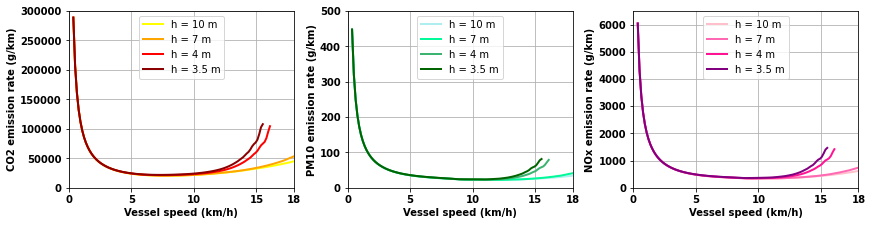

In [28]:
V_0_km= V_0 * 3.6
fig, axs = plt.subplots(1, 3, figsize=(12, 3),constrained_layout=True)
fontsize=10
ax=plt.subplot(131)

plt.plot(V_0_km, emission_g_m_CO2_1, 'yellow',linewidth = 2.0)
plt.plot(V_0_km, emission_g_m_CO2_2, 'orange',linewidth = 2.0)
plt.plot(V_0_km[V_0_km<16.1], emission_g_m_CO2_3[V_0_km<16.1], 'red',linewidth = 2.0)
plt.plot(V_0_km[V_0_km<15.6], emission_g_m_CO2_4[V_0_km<15.6], 'darkred',linewidth = 2.0)
plt.legend(['h = 10 m', 'h = 7 m', 'h = 4 m', 'h = 3.5 m'],loc='upper center')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 300000)
plt.xlabel('Vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('CO2 emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')

ax=plt.subplot(132)
plt.plot(V_0_km, emission_g_m_PM10_1, 'paleturquoise',linewidth = 2.0)
plt.plot(V_0_km, emission_g_m_PM10_2, 'mediumspringgreen',linewidth = 2.0)
plt.plot(V_0_km[V_0_km<16.1], emission_g_m_PM10_3[V_0_km<16.1], 'mediumseagreen',linewidth = 2.0)
plt.plot(V_0_km[V_0_km<15.6], emission_g_m_PM10_4[V_0_km<15.6], 'darkgreen',linewidth = 2.0)
plt.legend(['h = 10 m', 'h = 7 m', 'h = 4 m', 'h = 3.5 m'],loc='upper center')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 500)
plt.xlabel('Vessel speed (km/h)',fontsize=10,weight='bold',labelpad=3)
plt.ylabel('PM10 emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')

ax=plt.subplot(133)
plt.plot(V_0_km, emission_g_m_NOX_1, 'pink',linewidth = 2.0)
plt.plot(V_0_km, emission_g_m_NOX_2, 'hotpink',linewidth = 2.0)
plt.plot(V_0_km[V_0_km<16.1], emission_g_m_NOX_3[V_0_km<16.1], 'deeppink',linewidth = 2.0)
plt.plot(V_0_km[V_0_km<15.6], emission_g_m_NOX_4[V_0_km<15.6], 'purple',linewidth = 2.0)
plt.legend(['h = 10 m', 'h = 7 m', 'h = 4 m', 'h = 3.5 m'],loc='upper center')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 6500)
plt.xlabel('Vessel speed (km/h)',fontsize=10, weight='bold',labelpad=3)
plt.ylabel('NOx emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')

plt.savefig('emission rates versus speed with diff water depth.pdf', dpi=600, format='pdf')  

## Emission rate in g/km as a function of the velocity, for different engine ages (h=10m)

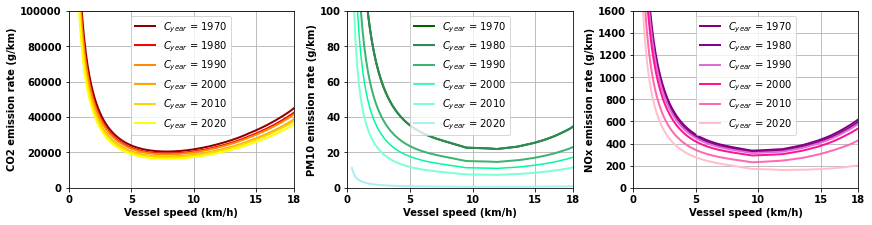

In [25]:
V_0_km= V_0 * 3.6
fig, axs = plt.subplots(1, 3, figsize=(12, 3),constrained_layout=True)
fontsize=10
ax=plt.subplot(131)

plt.plot(V_0_km, emission_g_m_CO2_11, 'darkred',linewidth = 2.0)
plt.plot(V_0_km, emission_g_m_CO2_22, 'red',linewidth = 2.0)
plt.plot(V_0_km, emission_g_m_CO2_33, 'darkorange',linewidth = 2.0)
plt.plot(V_0_km, emission_g_m_CO2_44, 'orange',linewidth = 2.0)
plt.plot(V_0_km, emission_g_m_CO2_55, 'gold',linewidth = 2.0)
plt.plot(V_0_km, emission_g_m_CO2_66, 'yellow',linewidth = 2.0)
plt.legend(['$C_{year}$ = 1970', '$C_{year}$ = 1980', '$C_{year}$ = 1990', '$C_{year}$ = 2000', 
            '$C_{year}$ = 2010', '$C_{year}$ = 2020'],loc='upper center')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 100000)
plt.xlabel('Vessel speed (km/h)',fontsize=10, weight='bold',labelpad=3)
plt.ylabel('CO2 emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18],weight = 'bold')
plt.yticks( weight = 'bold')

#fig.suptitle('CO2 emission rate versus velocity, for different engine ages  \n (type = M9, L = 135 m, B = 11.75 m, T = 2.75 m, h = 10 m)')
#plt.title('CO2 emission rate versus V0 (L = 135 m, B = 11.75 m, T = 2.4 m, c_year = 1990)')

ax=plt.subplot(132)
plt.plot(V_0_km, emission_g_m_PM10_11, 'darkgreen',linewidth = 2.0)
plt.plot(V_0_km, emission_g_m_PM10_22, 'seagreen',linewidth = 2.0)
plt.plot(V_0_km, emission_g_m_PM10_33, 'mediumseagreen',linewidth = 2.0)
plt.plot(V_0_km, emission_g_m_PM10_44, 'mediumspringgreen')
plt.plot(V_0_km, emission_g_m_PM10_55, 'aquamarine',linewidth = 2.0)
plt.plot(V_0_km, emission_g_m_PM10_66, 'paleturquoise',linewidth = 2.0)
plt.legend(['$C_{year}$ = 1970', '$C_{year}$ = 1980', '$C_{year}$ = 1990', '$C_{year}$ = 2000', 
            '$C_{year}$ = 2010', '$C_{year}$ = 2020'],loc='upper center')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 100)
plt.xlabel('Vessel speed (km/h)',fontsize=10, weight='bold',labelpad=3)
plt.ylabel('PM10 emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')

#fig.suptitle('PM10 emission rate versus velocity, for different engine ages \n (type = M9, L = 135 m, B = 11.4 m, T = 2.75 m, h = 10 m)')

ax=plt.subplot(133)
plt.plot(V_0_km, emission_g_m_NOX_11, 'purple',linewidth = 2.0)
plt.plot(V_0_km, emission_g_m_NOX_22, 'darkmagenta',linewidth = 2.0)
plt.plot(V_0_km, emission_g_m_NOX_33, 'orchid',linewidth = 2.0)
plt.plot(V_0_km, emission_g_m_NOX_44, 'deeppink',linewidth = 2.0)
plt.plot(V_0_km, emission_g_m_NOX_55, 'hotpink',linewidth = 2.0)
plt.plot(V_0_km, emission_g_m_NOX_66, 'pink',linewidth = 2.0)
plt.legend(['$C_{year}$ = 1970', '$C_{year}$ = 1980', '$C_{year}$ = 1990', '$C_{year}$ = 2000',
            '$C_{year}$ = 2010', '$C_{year}$ = 2020'],loc='upper center')
plt.grid()
plt.xlim(0, 18)
plt.ylim(0, 1600)
plt.xlabel('Vessel speed (km/h)',fontsize=10, weight='bold',labelpad=3)
plt.ylabel('NOx emission rate (g/km)',fontsize=10,weight='bold',labelpad=3)
plt.xticks([0,5,10,15,18], weight = 'bold')
plt.yticks( weight = 'bold')

plt.savefig('emission rates versus speed with diff engine ages.pdf', dpi=600, format='pdf')
#fig.suptitle('NOX emission rate versus velocity, for different engine ages  \n (type = M9, L = 135 m, B = 11.4 m, T = 2.75 m, h = 10 m)')